In [2]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import asyncio
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')
class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    summary: str

async def create_graph():
    client = MultiServerMCPClient({
        "dummy_server": {
            "command": "uv",
            "args": ["run", "mcpserver.py"],
            "transport": "stdio"
        }
    })
    llm = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash', temperature=0, google_api_key = GOOGLE_API_KEY)
    tools = await client.get_tools()

    llm_with_tools = llm.bind_tools(tools)
    
    sys_prompt = SystemMessage(str(await client.get_prompt(server_name="dummy_server", prompt_name="system_prompt")))
    # we can add a conditional loop here after human query, to give human options to make prompt less ambiguous
    def human_input(state: MessagesState):
        user_query = input('Enter your query: ')
        return {'messages': [HumanMessage(content=user_query)]}
    
    def agent_call(state: MessagesState):
        # summary will help reducing token count
        return {'messages': llm_with_tools.invoke([sys_prompt] + [state['summary']] + state['messages'])}

    builder = StateGraph(MessagesState)

    builder.add_node('Human', human_input)
    builder.add_node('Agent', agent_call)
    builder.add_node('tools', ToolNode(tools))
    # LOGIC
    builder.add_edge(START, 'Human')
    builder.add_edge('Human', 'Agent')
    builder.add_conditional_edges('Agent', tools_condition)
    builder.add_edge('tools', 'Human')

    memory = MemorySaver()
    graph = builder.compile(checkpointer=memory)

    return graph

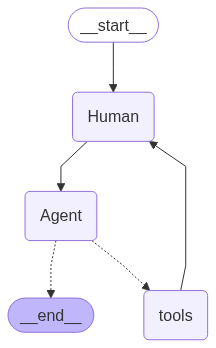

In [3]:
graph = await create_graph()

graph

In [6]:
thread_config = {'configurable': {'thread_id': 2}}

In [7]:
await graph.ainvoke({'messages': 'Hi', 'summary': ""}, thread_config)

Enter your query:  can you give area of region A
Enter your query:  hi


/Users/utkarshsharma/Desktop/Current_Projects/ConstructionAgent/.venv/lib/python3.11/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='c2e5a875-bb82-46f9-abab-db5dd44bb4b7'),
  HumanMessage(content='can you give area of region A', additional_kwargs={}, response_metadata={}, id='58d18e7b-ebca-4ace-91ab-41b8322509b9'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'measure_area', 'arguments': '{"region": "A"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--1458658b-ca65-4c77-a876-960fe535faaf-0', tool_calls=[{'name': 'measure_area', 'args': {'region': 'A'}, 'id': 'e07c5838-1e2f-43e7-8b60-34051f8383da', 'type': 'tool_call'}], usage_metadata={'input_tokens': 305, 'output_tokens': 5, 'total_tokens': 310, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='100', name='measure_area', id='37ffc2c5-491b-4194-aebd-73b123c642b2', tool_call_id='e07c5838-1e2f-43e7-8b60-34051f8383d